# AIPI 590 - XAI | Assignment #07
### Explainable Deep Learning
Developed a hypothesis below and designed a study using saliency maps to test the hypothesis.


### Keese Phillips


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/keesephillips/aipi590_xai/blob/main/assignment_7/assignment_7.ipynb)

In [ ]:
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "aipi590_xai"
git_path = 'https://github.com/keesephillips/aipi590_xai'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Change working directory to location of notebook
notebook_dir = 'asignment_7'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

# Hypothesis:
## H0:
> *Vanilla gradient (saliency maps) applied on a ResNet model will not show significant activation for the pixels around the eyes of animals*

## H1:
> *Vanilla gradient (saliency maps) applied on a ResNet model will show significant activation for the pixels around the eyes of animals*

# Approach:
The ResNet50 model will be implemented where the last fully connected layer will be replaced with a new fully connected layer matching the classes from the CIFAR10 dataset. The model will then be fine tuned on the CIFAR10 dataset. Finally the gradient of the class score is computed with respect to the input pixels. These gradients are then visualized next to their respective original image to determine the pixels that were most activated.

In [27]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision.models import resnet50, ResNet50_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [49]:
transform = transforms.Compose([
    transforms.Resize(224),  # ResNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.to(device)

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Training Loss: {train_loss/len(trainloader):.4f}')
    print(f'Validation Loss: {val_loss/len(testloader):.4f}')
    print()

print('Finished Training')

Epoch 1/5:
Training Loss: 0.0756
Validation Loss: 0.1061

Epoch 2/5:
Training Loss: 0.0407
Validation Loss: 0.1018

Epoch 3/5:
Training Loss: 0.0248
Validation Loss: 0.1015

Epoch 4/5:
Training Loss: 0.0169
Validation Loss: 0.1038

Epoch 5/5:
Training Loss: 0.0127
Validation Loss: 0.1057

Finished Training


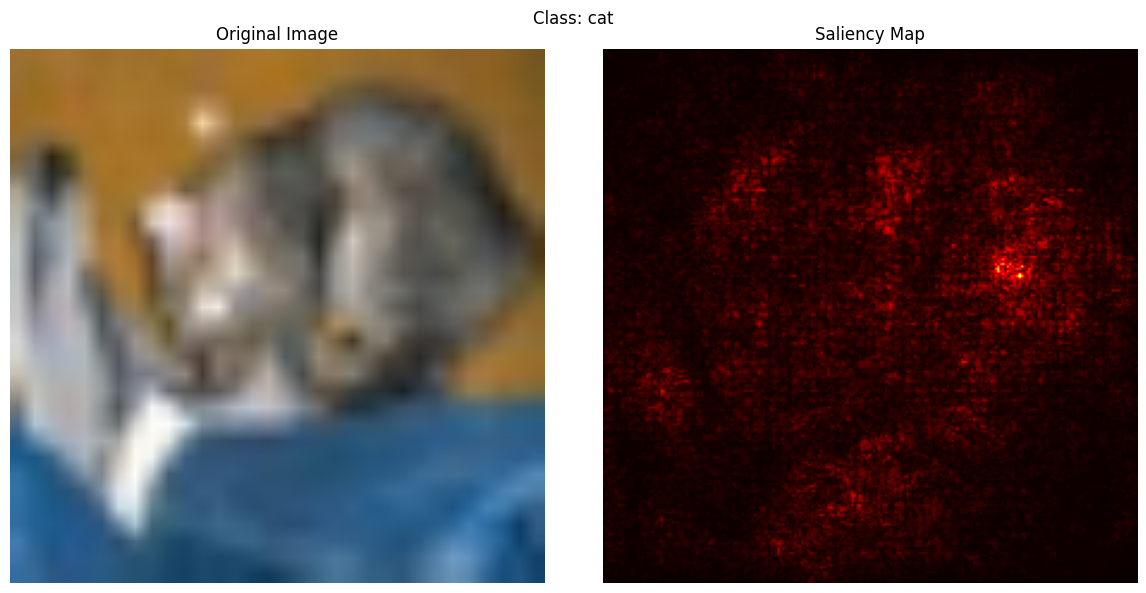

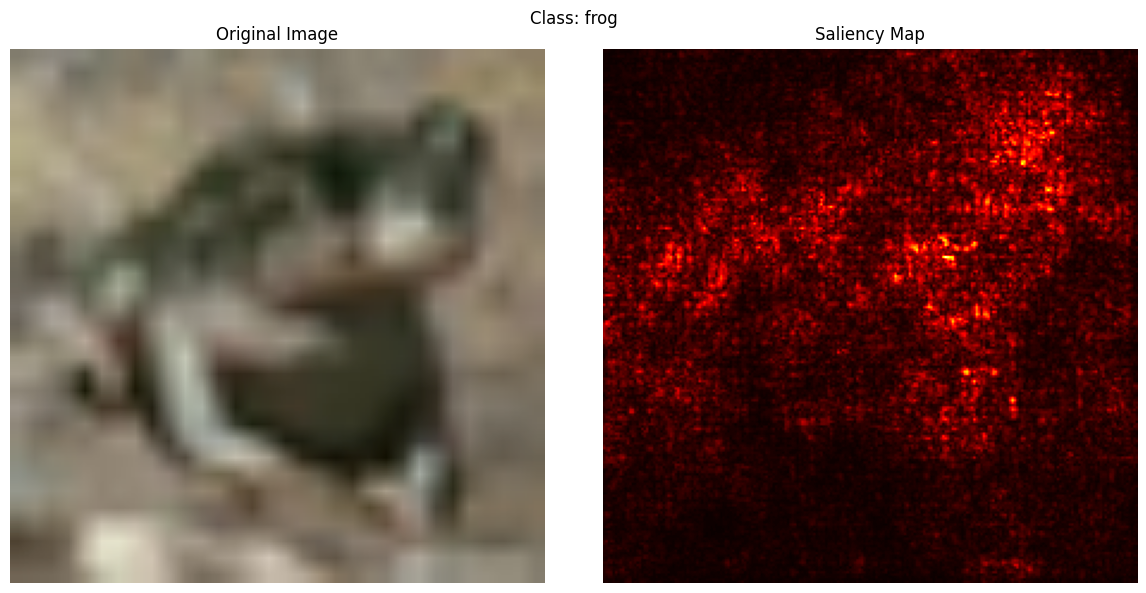

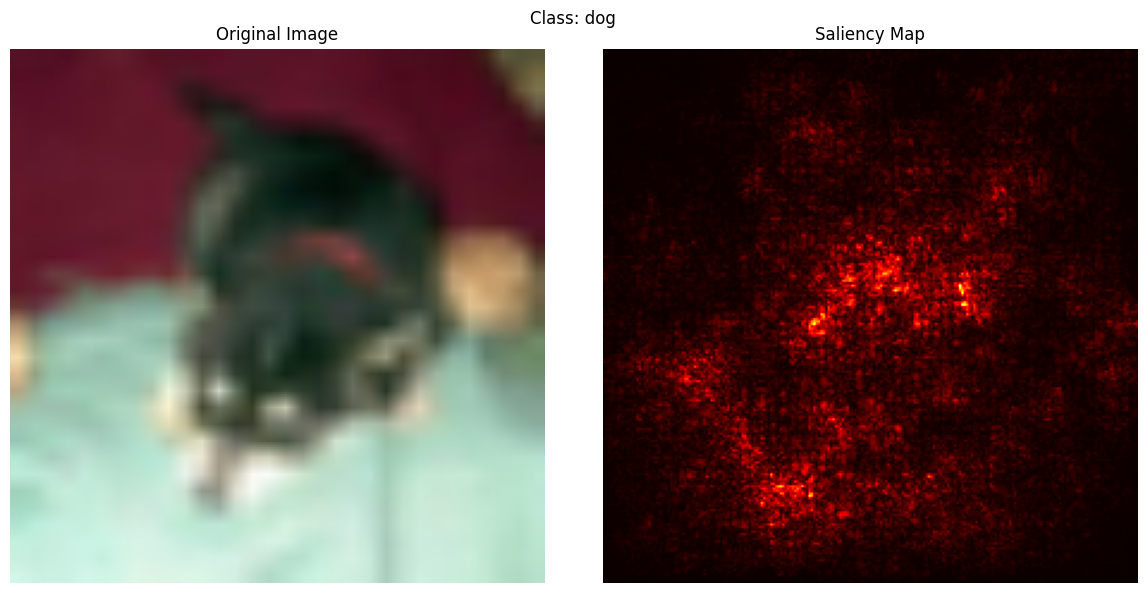

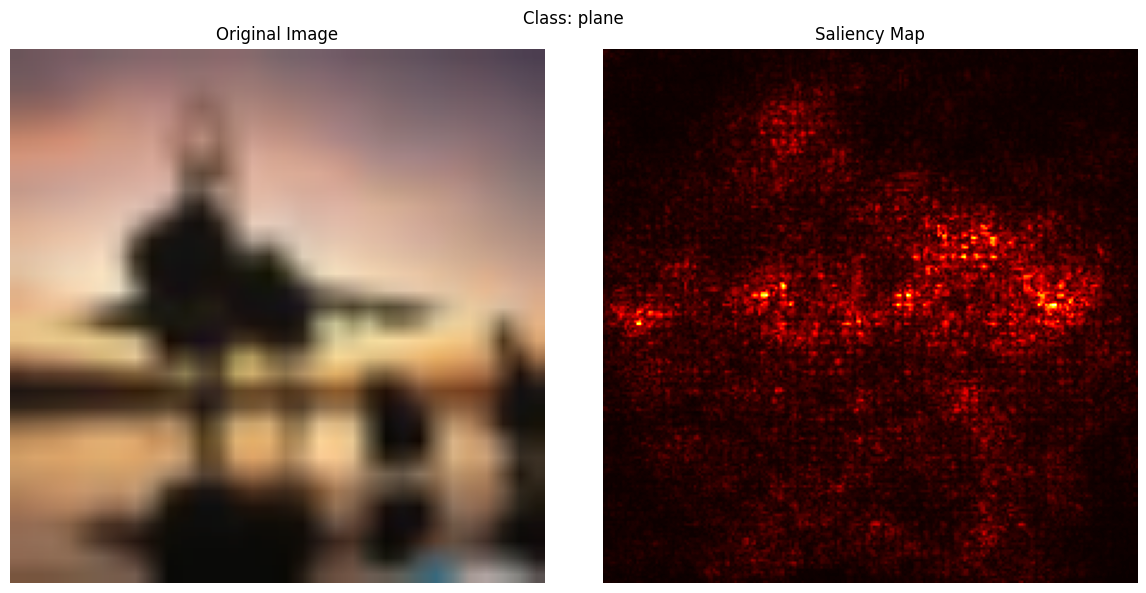

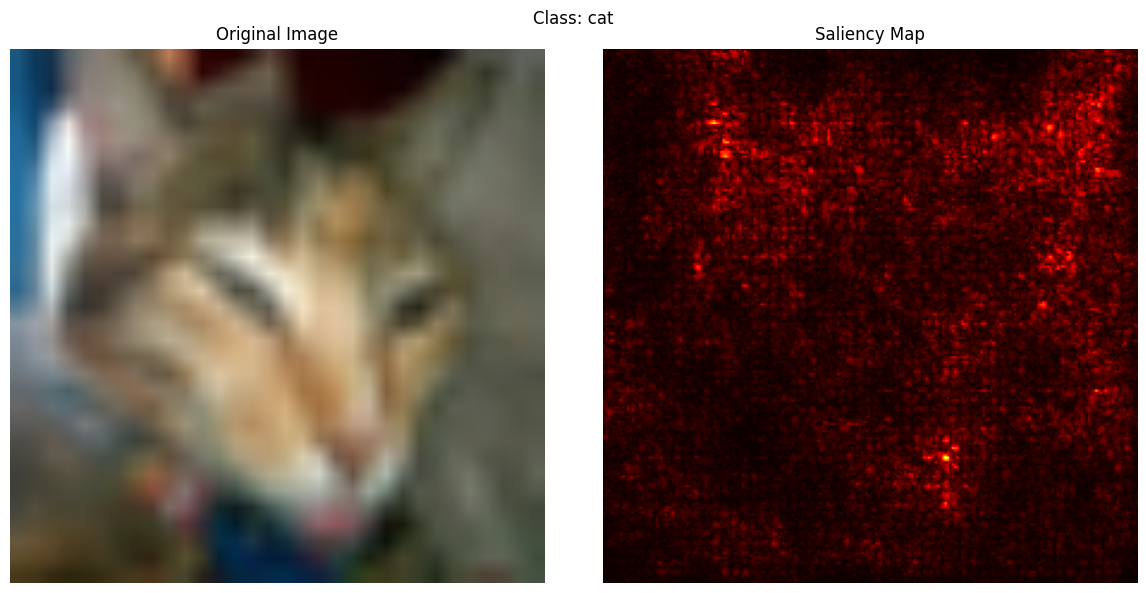

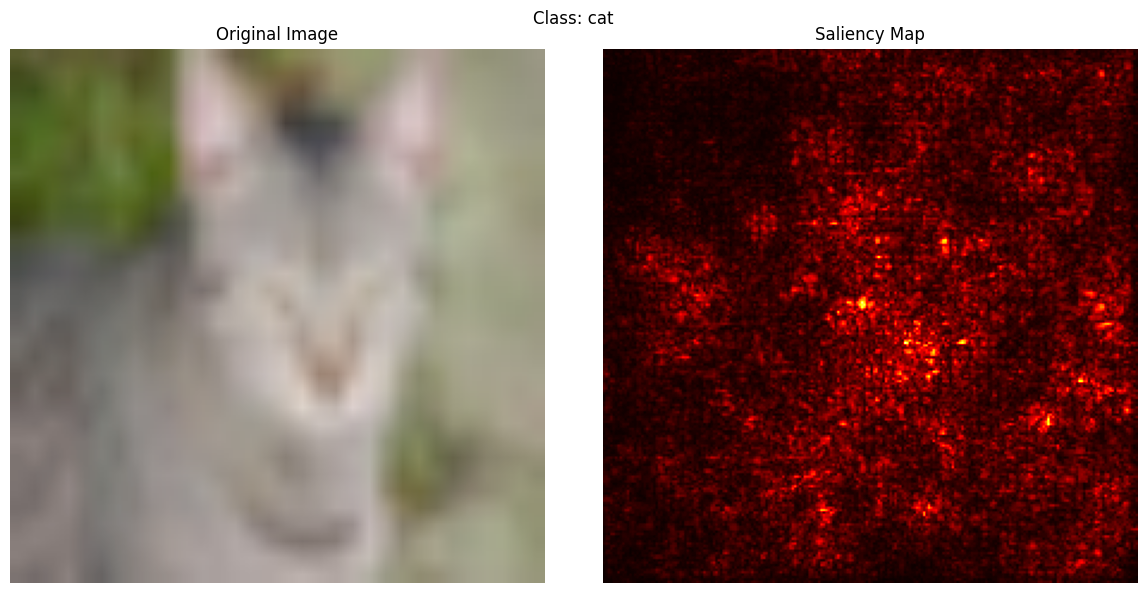

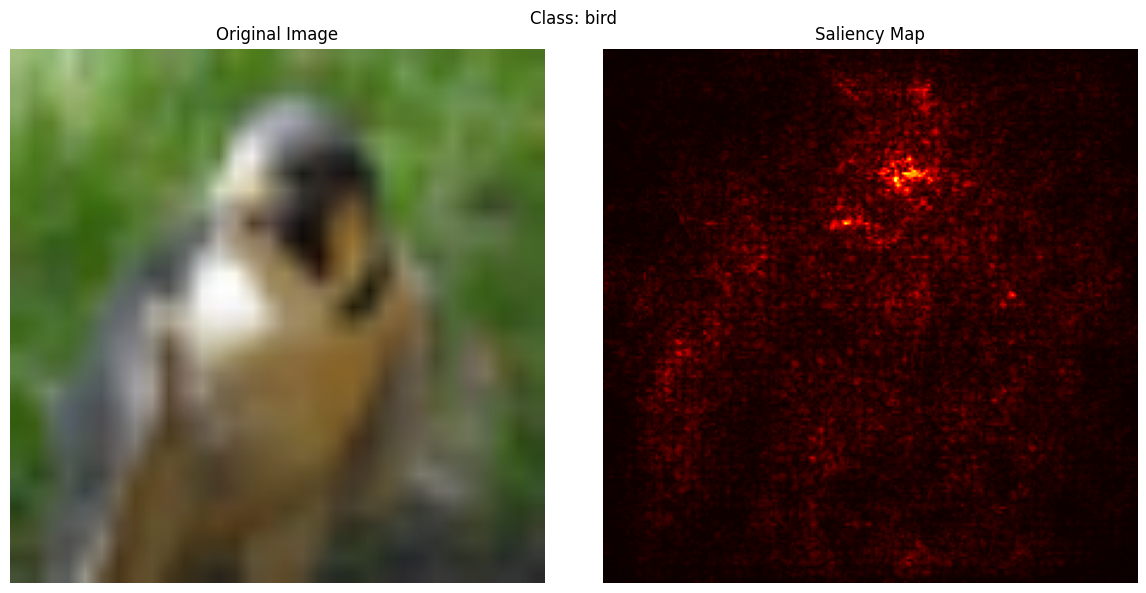

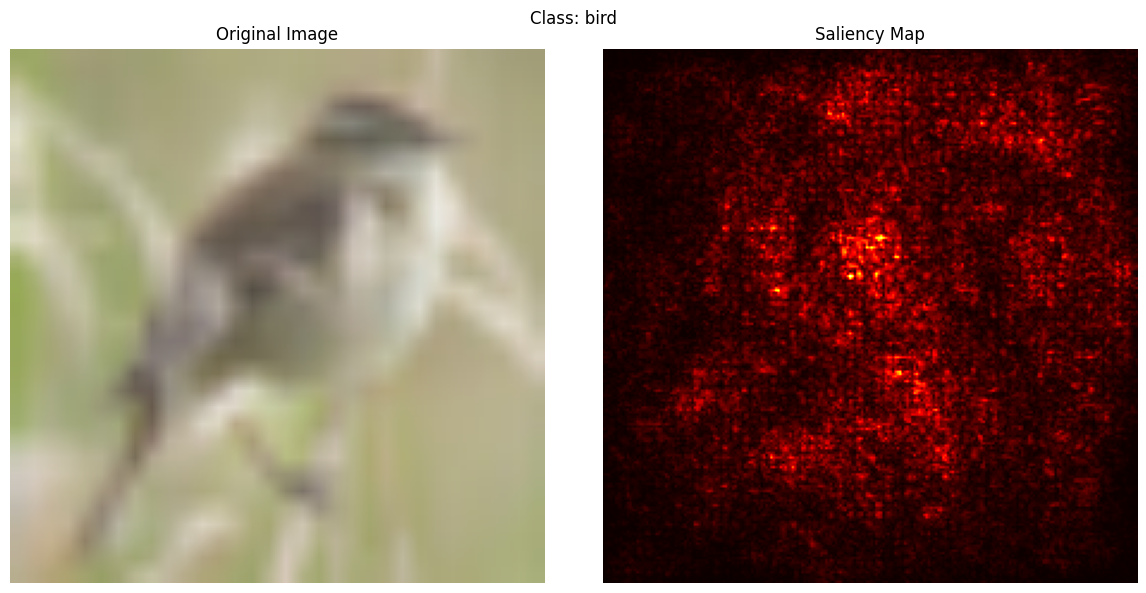

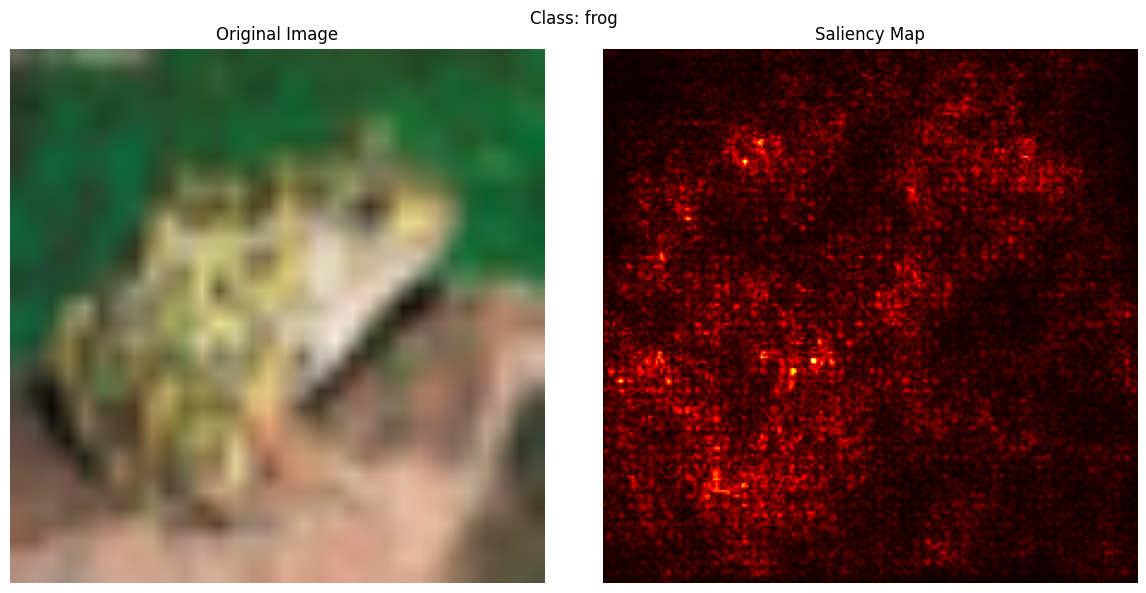

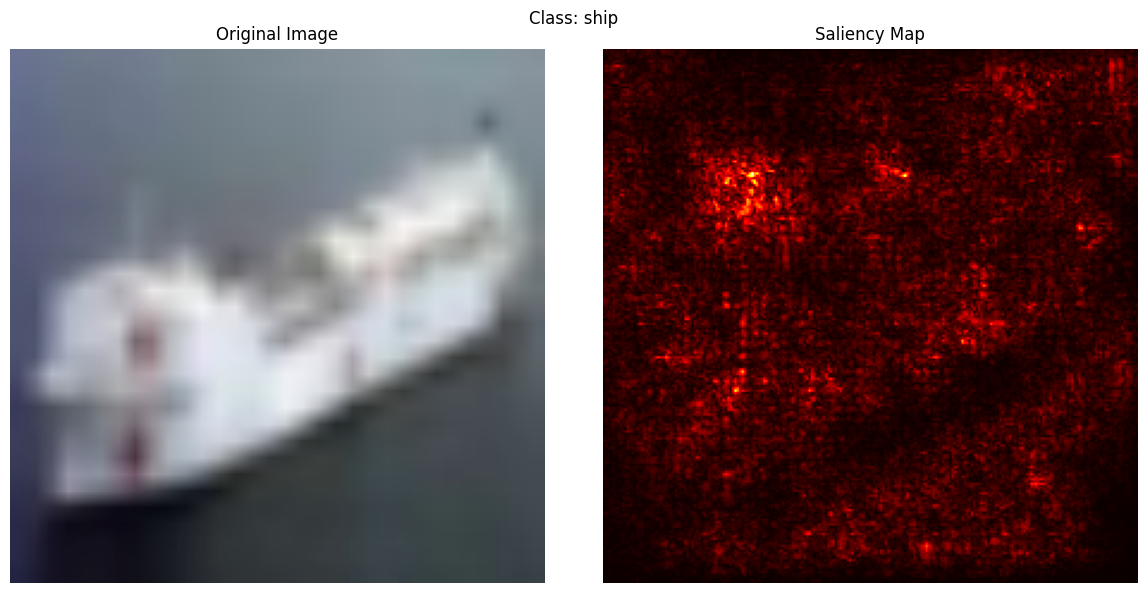

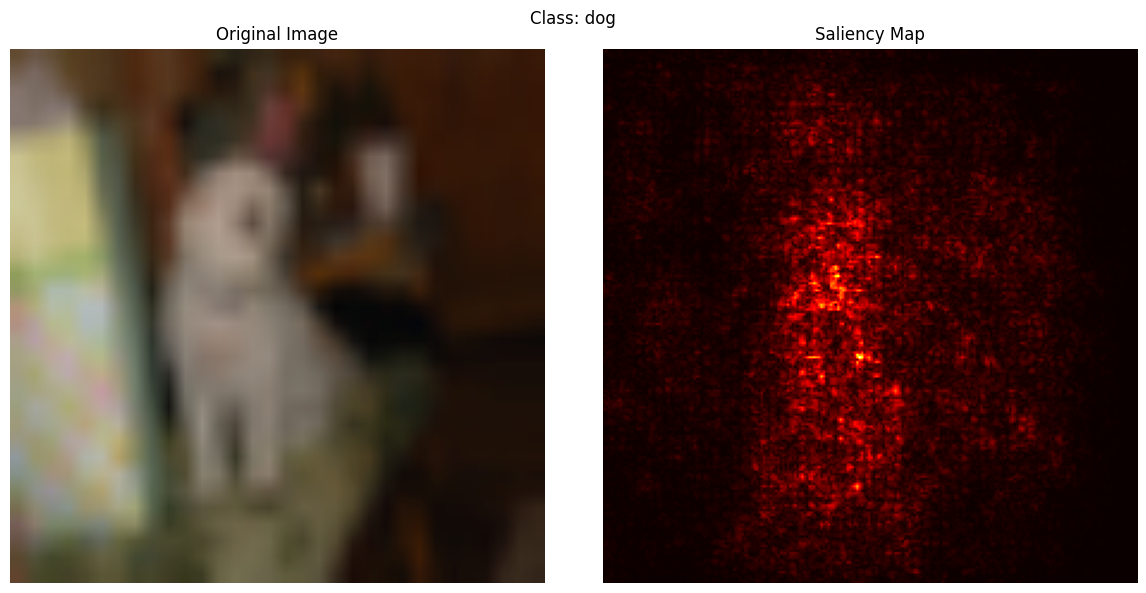

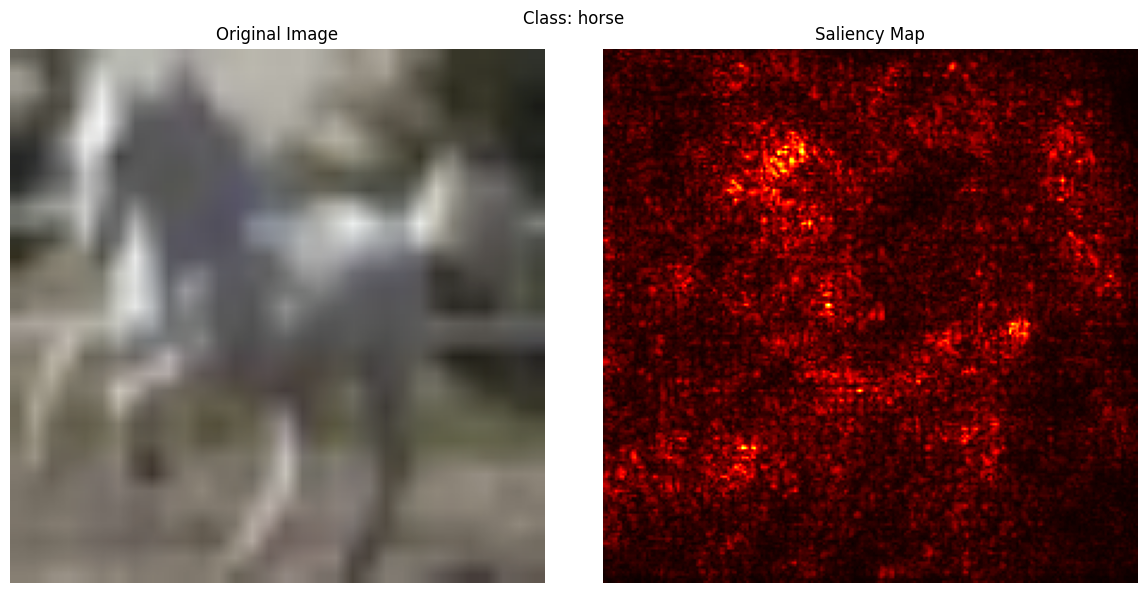

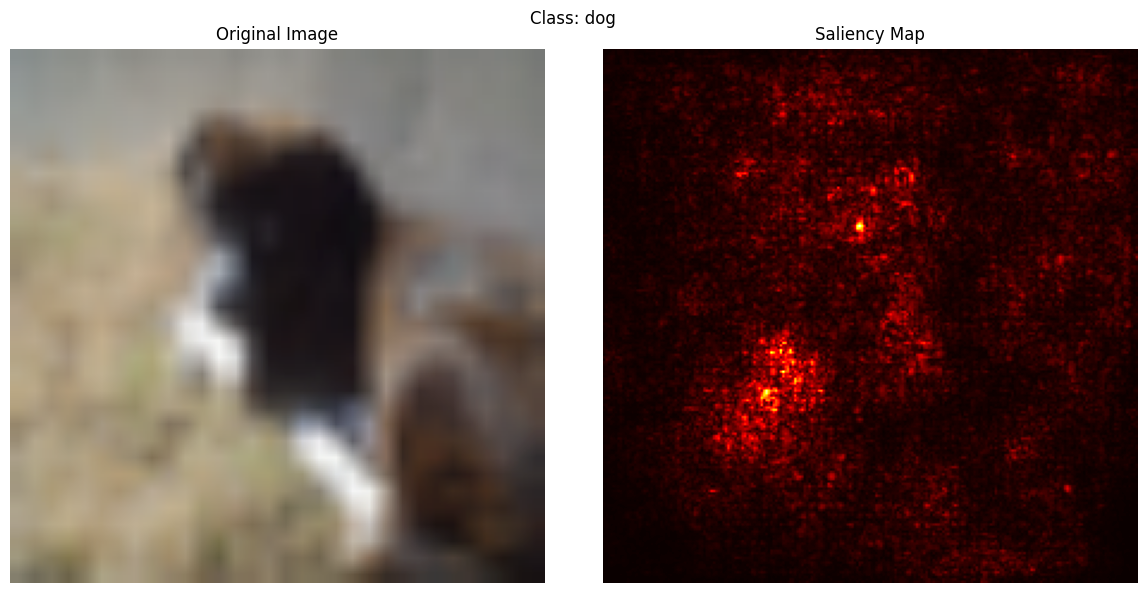

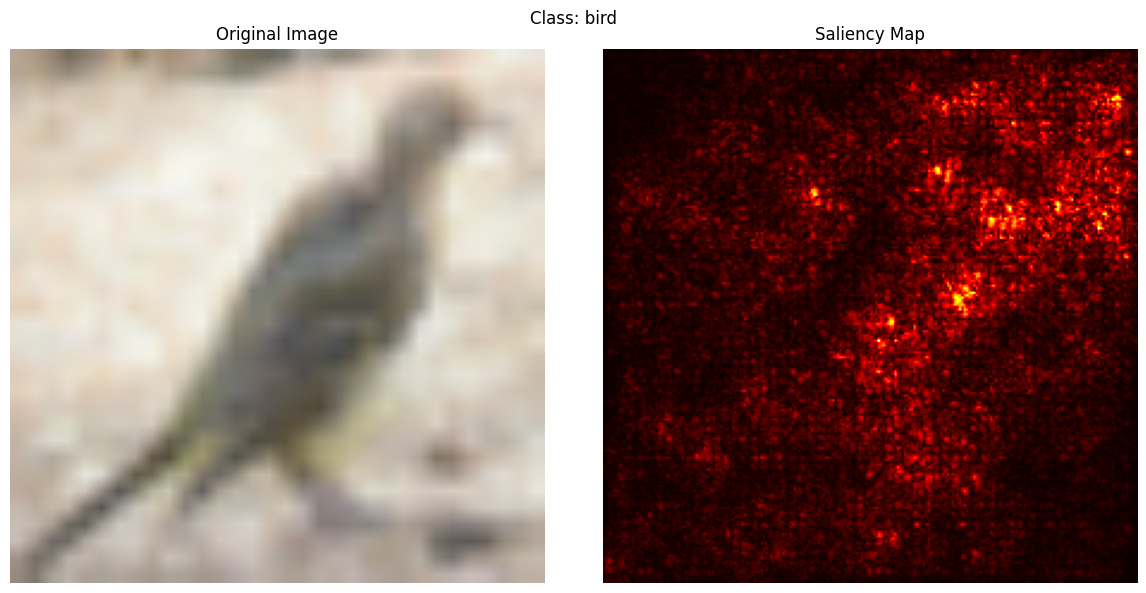

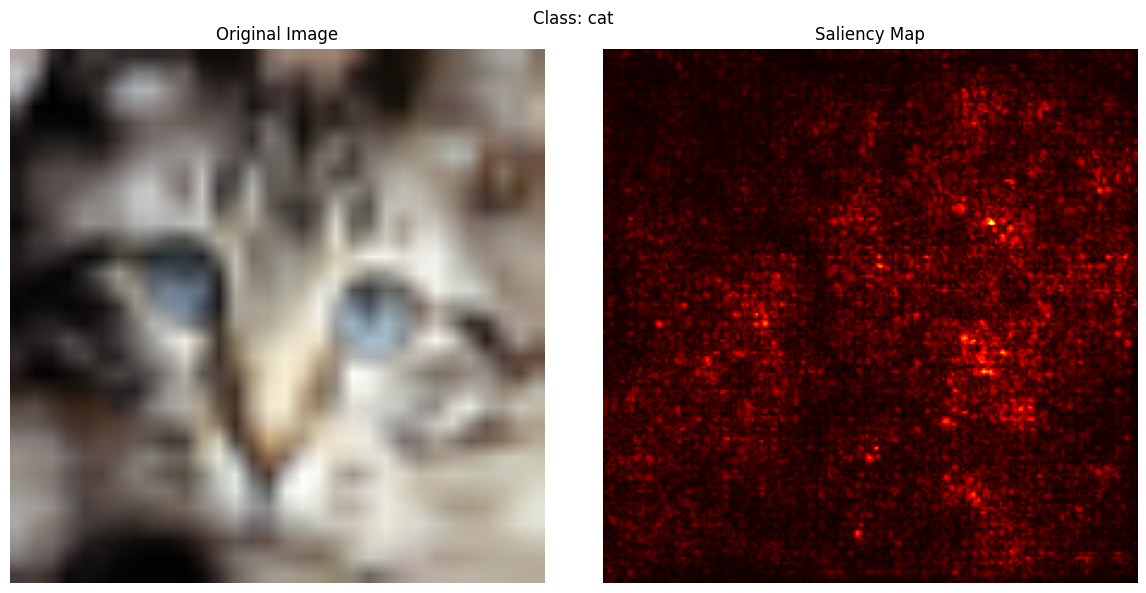

In [57]:
def generate_saliency_map(model, image, target_class):
    model.eval()
    image = image.unsqueeze(0).to(device)
    image.requires_grad_()

    output = model(image)
    output_idx = output.argmax()
    output_max = output[0, output_idx]

    output_max.backward()

    saliency, _ = torch.max(image.grad.data.abs(), dim=1)
    saliency = saliency.reshape(224, 224).cpu().data.numpy()

    return saliency

def show_saliency(image, saliency_map, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Original Image')

    ax2.imshow(saliency_map, cmap='hot')
    ax2.axis('off')
    ax2.set_title('Saliency Map')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

model.eval()
for i, (images, labels) in enumerate(testloader):
    if i == 15:
        break

    image = images[0].cpu()
    label = labels[0].item()

    saliency = generate_saliency_map(model, image.to(device), label)

    img_np = image.permute(1, 2, 0).numpy()
    img_np = (img_np * [0.2023, 0.1994, 0.2010] + [0.4914, 0.4822, 0.4465]) * 255
    img_np = img_np.astype(np.uint8)

    show_saliency(img_np, saliency, f'Class: {classes[label]}')

# Summary:
The ResNet50 model does not appear to have a strong correlation between the pixel area around the eyes and the activation on the saliency maps. Therefore, the null hypothesis is accepted and because the ResNet model does not show significant activation around the eyes of the various animals. The saliency maps seem to suggest the activation area appears most pronound in animals in the ear region. This is especially true in cats where the activation appears the strongest.